In [75]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams

plt.style.use("ggplot")
%matplotlib inline

random.seed(1)
torch.manual_seed(1)

# Datasets

In [76]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())


# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model

In [77]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.logger = get_logger(logging.DEBUG, logging.DEBUG)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(320, num_classes)
        
    def log(self, msg):
        if self.logger:
            self.logger.debug(msg)
    
    def forward(self, x):
        in_size = x.size(0)
        x = torch.relu(self.mp(self.conv1(x)))
        x = torch.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)
        x = self.fc(x)
        return x

#### Methods

In [78]:
def train(model, dataloader, criterion, optimizer, epoch=1):
    model.train()
    total_loss = 0
    total_acc = 0
    n_batches = len(dataloader)
    for inputs, targets in dataloader:
        ## Forward Pass
        output = net(inputs)
        ## Clear Gradients
        net.zero_grad()
        loss = criterion(output, targets)
        ## Backprop
        loss.backward()
        optimizer.step()
        ## prediction and accuracy
        outputs = model(inputs)
        accuracy = get_accuracy(outputs, targets) 
        total_loss += loss.item()
        total_acc += accuracy
    mean_loss = total_loss / n_batches
    mean_acc = total_acc / n_batches
    return mean_loss, mean_acc

def get_accuracy(preds, targets):
    _, predicted = torch.max(preds.data, 1)
    total = targets.size(0)
    correct = (predicted == targets).sum()           
    return (100 * correct / total)

def test(model, test_loader, criterion, epoch=1):
    model.eval()
    test_loss = 0
    test_acc = 0
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels) 
        test_loss += loss.item()
        test_acc += get_accuracy(outputs, labels)
    test_loss /= len(test_loader) #n_batches
    test_acc /= len(test_loader)
    return test_loss, test_acc

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()

## Network Visiulization

In [79]:
# number of percentile slices for histogram visualisations
HISTOGRAM_BUCKETS = 7

# X: tensor of shape [100+, 28, 28, 1] containing a batch of images (float32)
# Y: tensor of shape [100+, 10] containing recognised digits (one-hot vectors)
# Y_: tensor of shape [100+, 10] containing correct digit labels (one-hot vectors)
# return value: tensor of shape [280, 280, 3] containing the 100 first unrecognised images (rgb, uint8)
# followed by other, recognised images. 100 images max arranged as a 10x10 array. Unrecognised images
# are displayed on a red background and labeled with the correct (left) and recognised digit (right.
# def tf_format_mnist_images(X, Y, Y_, n=100, lines=10):
#     correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
#     correctly_recognised_indices = tf.squeeze(tf.where(correct_prediction), [1])  # indices of correctly recognised images
#     incorrectly_recognised_indices = tf.squeeze(tf.where(tf.logical_not(correct_prediction)), [1]) # indices of incorrectly recognised images
#     everything_incorrect_first = tf.concat([incorrectly_recognised_indices, correctly_recognised_indices], 0) # images reordered with indeces of unrecognised images first
#     everything_incorrect_first = tf.slice(everything_incorrect_first, [0], [n]) # compute first 100 only - no space to display more anyway
#     # compute n=100 digits to display only
#     Xs = tf.gather(X, everything_incorrect_first)
#     Ys = tf.gather(Y, everything_incorrect_first)
#     Ys_ = tf.gather(Y_, everything_incorrect_first)
#     correct_prediction_s = tf.gather(correct_prediction, everything_incorrect_first)

#     digits_left = tf.image.grayscale_to_rgb(tensorflowvisu_digits.digits_left())
#     correct_tags = tf.gather(digits_left, tf.argmax(Ys_, 1)) # correct digits to be printed on the images
#     digits_right = tf.image.grayscale_to_rgb(tensorflowvisu_digits.digits_right())
#     computed_tags = tf.gather(digits_right, tf.argmax(Ys, 1)) # computed digits to be printed on the images
#     #superimposed_digits = correct_tags+computed_tags
#     superimposed_digits = tf.where(correct_prediction_s, tf.zeros_like(correct_tags),correct_tags+computed_tags) # only pring the correct and computed digits on unrecognised images
#     correct_bkg   = tf.reshape(tf.tile([1.3,1.3,1.3], [28*28]), [1, 28,28,3]) # white background
#     incorrect_bkg = tf.reshape(tf.tile([1.3,1.0,1.0], [28*28]), [1, 28,28,3]) # red background
#     recognised_bkg = tf.gather(tf.concat([incorrect_bkg, correct_bkg], 0), tf.cast(correct_prediction_s, tf.int32)) # pick either the red or the white background depending on recognised status

#     I = tf.image.grayscale_to_rgb(Xs)
#     I = ((1-(I+superimposed_digits))*recognised_bkg)/1.3 # stencil extra data on top of images and reorder them unrecognised first
#     I = tf.image.convert_image_dtype(I, tf.uint8, saturate=True)
#     Islices = [] # 100 images => 10x10 image block
#     for imslice in range(lines):
#         Islices.append(tf.concat(tf.unstack(tf.slice(I, [imslice*n//lines,0,0,0], [n//lines,28,28,3])), 1))
#     I = tf.concat(Islices, 0)
#     return I

In [83]:


# n = HISTOGRAM_BUCKETS (global)
# Buckets the data into n buckets so that there are an equal number of data points in
# each bucket. Returns n+1 bucket boundaries. Spreads the reaminder data.size % n more
# or less evenly among the central buckets.
# data: 1-D ndarray containing float data, MUST BE SORTED in ascending order
#    n: integer, the number of desired output buckets
# return value: ndarray, 1-D vector of size n+1 containing the bucket boundaries
#               the first value is the min of the data, the last value is the max
def probability_distribution(data):
    n = HISTOGRAM_BUCKETS
    data.sort()
    bucketsize = data.size // n
    bucketrem  = data.size % n
    buckets = np.zeros([n+1])
    buckets[0] = data[0]  # min
    buckets[-1] = data[-1]  # max
    buckn = 0
    rem = 0
    remn = 0
    k = 0
    cnt = 0 # only for assert
    lastval = data[0]
    for i in range(data.size):
        val = data[i]
        buckn += 1
        cnt += 1
        if buckn > bucketsize+rem : ## crossing bucket boundary
            cnt -= 1
            k += 1
            buckets[k] = (val + lastval) / 2
            if (k<n+1):
                cnt += 1
            buckn = 1 # val goes into the new bucket
            if k >= (n - bucketrem) // 2 and remn < bucketrem:
                rem = 1
                remn += 1
            else:
                rem = 0
        lastval = val
    assert i+1 == cnt
    return buckets

def _empty_collection(collection):
    tempcoll = []
    for a in (collection):
        tempcoll.append(a)
    for a in (tempcoll):
        collection.remove(a)

def _display_time_histogram(ax, xdata, ydata, color):
    _empty_collection(ax.collections)
    midl = HISTOGRAM_BUCKETS//2
    midh = HISTOGRAM_BUCKETS//2
    for i in range(int(math.ceil(HISTOGRAM_BUCKETS/2.0))):
        ax.fill_between(xdata, ydata[:,midl-i], ydata[:,midh+1+i], facecolor=color, alpha=1.6/HISTOGRAM_BUCKETS)
        if HISTOGRAM_BUCKETS % 2 == 0 and i == 0:
            ax.fill_between(xdata, ydata[:,midl-1], ydata[:,midh], facecolor=color, alpha=1.6/HISTOGRAM_BUCKETS)
            midl = midl-1

class MnistDataVis:
    xmax = 0
    y2max = 0
    x1 = []
    y1 = []
    z1 = []
    x2 = []
    y2 = []
    z2 = []
    x3 = []
    w3 = np.zeros([0,HISTOGRAM_BUCKETS+1])
    b3 = np.zeros([0,HISTOGRAM_BUCKETS+1])
    im1 = np.full((28*10,28*10,3),255, dtype='uint8')
    im2 = np.full((28*10,28*10,3),255, dtype='uint8')
    _animpause = False
    _animation = None
    _mpl_figure = None
    _mlp_init_func = None
    _mpl_update_func = None
    _color4 = None
    _color5 = None

    def __set_title(self, ax, title, default=""):
        if title is not None and title != "":
            ax.set_title(title, y=1.02) # adjustment for plot title bottom margin
        else:
            ax.set_title(default, y=1.02) # adjustment for plot title bottom margin

    #  retrieve the color from the color cycle, default is 1
    def __get_histogram_cyclecolor(self, colornum):
        clist = rcParams['axes.prop_cycle']
        ccount = 1 if (colornum is None) else colornum
        colors = clist.by_key()['color']
        for i, c in enumerate(colors):
            if (i == ccount % 3):
                return c

    def __init__(self, title1=None, title2=None, title3=None, title4=None, title5=None, title6=None, histogram4colornum=None, histogram5colornum=None, dpi=70):
        self._color4 = self.__get_histogram_cyclecolor(histogram4colornum)
        self._color5 = self.__get_histogram_cyclecolor(histogram5colornum)
        fig = plt.figure(figsize=(19.20,10.80), dpi=dpi)
        plt.gcf().canvas.set_window_title("MNIST")
        fig.set_facecolor('#FFFFFF')
        ax1 = fig.add_subplot(231)
        ax2 = fig.add_subplot(232)
        ax3 = fig.add_subplot(233)
        ax4 = fig.add_subplot(234)
        ax5 = fig.add_subplot(235)
        ax6 = fig.add_subplot(236)
        #fig, ax = plt.subplots() # if you need only 1 graph

        self.__set_title(ax1, title1, default="Accuracy")
        self.__set_title(ax2, title2, default="Cross entropy loss")
        self.__set_title(ax3, title3, default="Training digits")
        self.__set_title(ax4, title4, default="Weights")
        self.__set_title(ax5, title5, default="Biases")
        self.__set_title(ax6, title6, default="Test digits")

        #ax1.set_figaspect(1.0)

        # TODO: finish exporting the style modifications into a stylesheet
        line1, = ax1.plot(self.x1, self.y1, label="training accuracy")
        line2, = ax1.plot(self.x2, self.y2, label="test accuracy")
        legend = ax1.legend(loc='lower right') # fancybox : slightly rounded corners
        legend.set_draggable(True)

        line3, = ax2.plot(self.x1, self.z1, label="training loss")
        line4, = ax2.plot(self.x2, self.z2, label="test loss")
        legend = ax2.legend(loc='upper right') # fancybox : slightly rounded corners
        legend.set_draggable(True)

        ax3.grid(False) # toggle grid off
        ax3.set_axis_off()
        imax1 = ax3.imshow(self.im1, animated=True, cmap='binary', vmin=0.0, vmax=1.0, interpolation='nearest', aspect=1.0)

        ax6.grid(False) # toggle grid off
        ax6.axes.get_xaxis().set_visible(False)
        imax2 = ax6.imshow(self.im2, animated=True, cmap='binary', vmin=0.0, vmax=1.0, interpolation='nearest', aspect=1.0)
        ax6.locator_params(axis='y', nbins=7)
        # hack...
        ax6.set_yticks([0, 280-4*56, 280-3*56, 280-2*56, 280-56, 280])
        ax6.set_yticklabels(["100%", "98%", "96%", "94%", "92%", "90%"])

        def _init():
            ax1.set_xlim(0, 10)  # initial value only, autoscaled after that
            ax2.set_xlim(0, 10)  # initial value only, autoscaled after that
            ax4.set_xlim(0, 10)  # initial value only, autoscaled after that
            ax5.set_xlim(0, 10)  # initial value only, autoscaled after that
            ax1.set_ylim(0, 1)    # important: not autoscaled
            #ax1.autoscale(axis='y')
            ax2.set_ylim(0, 100)  # important: not autoscaled
            return imax1, imax2, line1, line2, line3, line4


        def _update():
            # x scale: iterations
            ax1.set_xlim(0, self.xmax+1)
            ax2.set_xlim(0, self.xmax+1)
            ax4.set_xlim(0, self.xmax+1)
            ax5.set_xlim(0, self.xmax+1)

            # four curves: train and test accuracy, train and test loss
            line1.set_data(self.x1, self.y1)
            line2.set_data(self.x2, self.y2)
            line3.set_data(self.x1, self.z1)
            line4.set_data(self.x2, self.z2)

            #images
            imax1.set_data(self.im1)
            imax2.set_data(self.im2)

            # histograms
            _display_time_histogram(ax4, self.x3, self.w3, self._color4)
            _display_time_histogram(ax5, self.x3, self.b3, self._color5)

            #return changed artists
            return imax1, imax2, line1, line2, line3, line4

        def _key_event_handler(event):
            if len(event.key) == 0:
                return
            else:
                keycode = event.key

            # pause/resume with space bar
            if keycode == ' ':
                self._animpause = not self._animpause
                if not self._animpause:
                    _update()
                return

            # [p, m, n] p is the #of the subplot, [n,m] is the subplot layout
            toggles = {'1':[1,1,1], # one plot
                       '2':[2,1,1], # one plot
                       '3':[3,1,1], # one plot
                       '4':[4,1,1], # one plot
                       '5':[5,1,1], # one plot
                       '6':[6,1,1], # one plot
                       '7':[12,1,2], # two plots
                       '8':[45,1,2], # two plots
                       '9':[36,1,2], # two plots
                       'escape':[123456,2,3], # six plots
                       '0':[123456,2,3]} # six plots

            # other matplotlib keyboard shortcuts:
            # 'o' box zoom
            # 'p' mouse pan and zoom
            # 'h' or 'home' reset
            # 's' save
            # 'g' toggle grid (when mouse is over a plot)
            # 'k' toggle log/lin x axis
            # 'l' toggle log/lin y axis

            if not (keycode in toggles):
                return

            for i in range(6):
                fig.axes[i].set_visible(False)

            fignum = toggles[keycode][0]
            if fignum <= 6:
                fig.axes[fignum-1].set_visible(True)
                fig.axes[fignum-1].change_geometry(toggles[keycode][1], toggles[keycode][2], 1)
                ax6.set_aspect(25.0/40) # special case for test digits
            elif fignum < 100:
                fig.axes[fignum//10-1].set_visible(True)
                fig.axes[fignum//10-1].change_geometry(toggles[keycode][1], toggles[keycode][2], 1)
                fig.axes[fignum%10-1].set_visible(True)
                fig.axes[fignum%10-1].change_geometry(toggles[keycode][1], toggles[keycode][2], 2)
                ax6.set_aspect(1.0) # special case for test digits
            elif fignum == 123456:
                for i in range(6):
                    fig.axes[i].set_visible(True)
                    fig.axes[i].change_geometry(toggles[keycode][1], toggles[keycode][2], i+1)
                ax6.set_aspect(1.0) # special case for test digits

            plt.draw()

        fig.canvas.mpl_connect('key_press_event', _key_event_handler)

        self._mpl_figure = fig
        self._mlp_init_func = _init
        self._mpl_update_func = _update

    def _update_xmax(self, x):
        if (x > self.xmax):
            self.xmax = x

    def _update_y2max(self, y):
        if (y > self.y2max):
            self.y2max = y

    def append_training_curves_data(self, x, accuracy, loss):
        self.x1.append(x)
        self.y1.append(accuracy)
        self.z1.append(loss)
        self._update_xmax(x)

    def append_test_curves_data(self, x, accuracy, loss):
        self.x2.append(x)
        self.y2.append(accuracy)
        self.z2.append(loss)
        self._update_xmax(x)
        self._update_y2max(accuracy)

    def get_max_test_accuracy(self):
        return self.y2max

    def append_data_histograms(self, x, datavect1, datavect2, title1=None, title2=None):
        self.x3.append(x)
        datavect1.sort()
        self.w3 = np.concatenate((self.w3, np.expand_dims(probability_distribution(datavect1), 0)))
        datavect2.sort()
        self.b3 = np.concatenate((self.b3, np.expand_dims(probability_distribution(datavect2), 0)))
        self._update_xmax(x)

    def update_image1(self, im):
        self.im1 = im

    def update_image2(self, im):
        self.im2 = im

    def is_paused(self):
        return self._animpause

    def animate(self, compute_step, iterations, train_data_update_freq=20, test_data_update_freq=100, one_test_at_start=True, more_tests_at_start=False, save_movie=False):

        def animate_step(i):
            if (i == iterations // train_data_update_freq): #last iteration
                compute_step(iterations, True, True)
            else:
                for k in range(train_data_update_freq):
                    n = i * train_data_update_freq + k
                    request_data_update = (n % train_data_update_freq == 0)
                    request_test_data_update = (n % test_data_update_freq == 0) and (n > 0 or one_test_at_start)
                    if more_tests_at_start and n < test_data_update_freq: request_test_data_update = request_data_update
                    compute_step(n, request_test_data_update, request_data_update)
                    # makes the UI a little more responsive
                    plt.pause(0.001)
            if not self.is_paused():
                return self._mpl_update_func()

        self._animation = animation.FuncAnimation(self._mpl_figure, animate_step, int(iterations // train_data_update_freq + 1), init_func=self._mlp_init_func, interval=16, repeat=False, blit=False)

        if save_movie:
            mywriter = animation.FFMpegWriter(fps=24, codec='libx264', extra_args=['-pix_fmt', 'yuv420p', '-profile:v', 'high', '-tune', 'animation', '-crf', '18'])
            self._animation.save("./tensorflowvisu_video.mp4", writer=mywriter)
        else:
            plt.show(block=True)


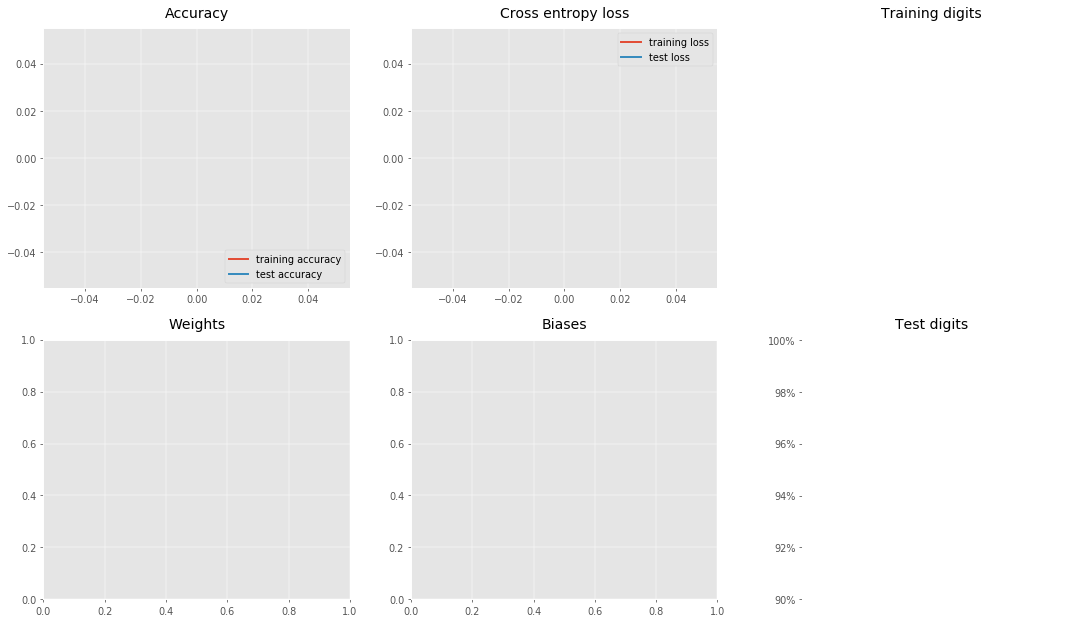

In [85]:
model = CNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
datavis = MnistDataVis()

NameError: name 'training_step' is not defined

In [87]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    total_acc = 0
    n_batches = len(dataloader)
    for inputs, targets in dataloader:
        ## Forward Pass
        output = model(inputs)
        ## Clear Gradients
        model.zero_grad()
        loss = criterion(output, targets)
        ## Backprop
        loss.backward()
        optimizer.step()
        ## prediction and accuracy
        outputs = model(images)
        accuracy = get_accuracy(outputs, targets) 
        total_loss += loss.item()
        total_acc += accuracy
    mean_loss = total_loss / n_batches
    mean_acc = total_acc / n_batches
    return mean_loss, mean_acc

def get_accuracy(preds, targets):
    _, predicted = torch.max(preds.data, 1)
    total = targets.size(0)
    correct = (predicted == labels).sum()           
    return (100 * correct / total)

In [88]:
datavis.animate(train, 2, train_data_update_freq=20, test_data_update_freq=100)


In [ ]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))